In [311]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
from src.data_processing import process_file, compute_physical, process_file_from_wizard, split_experiments
from scipy.integrate import odeint

folder_path = "data/exp15_02/*.csv"
folder_path = "data/exp15_02/without_J_ext_2/*.csv"

# List to store each processed dataframe
processed_dataframes = []

# Iterate over all CSV files in the folder
for file_path in glob.glob(folder_path):
    # Apply processing function to the dataframe
    processed_df = process_file_from_wizard(file_path)

    # processed_df = split_experiments(processed_df)
    
    # Store the processed dataframe in the list
    processed_dataframes.append(processed_df)

external_inertia = 0.0022421143208 # Msolo
Ra = 9.3756 # [Ohm]
kt = 2.6657
ke = 0.8594
ke = 3.75286

parameters = ke, kt, Ra, 0.080964165, 0.0665140867408596, 0.203719639, 0.04217117990939209, 0.0155818308

len(processed_dataframes)

10

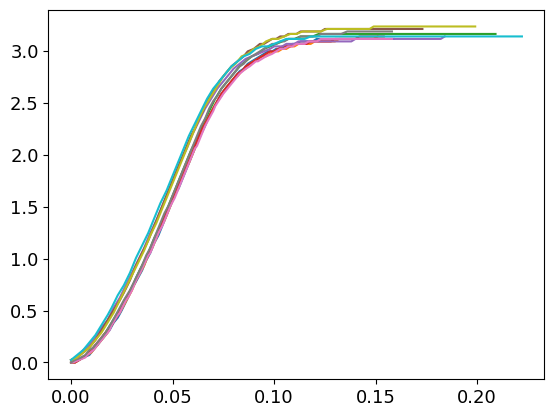

In [312]:
def find_indices_of_start(df):
    indices_of_change = []
    for i in range(len(df) - 1):
        if df['U'].iloc[i] == 0 and df['U'].iloc[i + 1] != 0:
            indices_of_change.append(i)
    return indices_of_change

df_starting = []
for df in processed_dataframes:
    index = find_indices_of_start(df)[0]
    df = df[index+4:index+80].reset_index(drop=True)
    # df = df[(df['U'] == 0) & (df['U'].shift(1) != 0)][:].reset_index(drop=True)
    plt.plot(df['t']-df['t'].iloc[0], abs(df['DXL_Velocity']))
    df_starting.append(df)


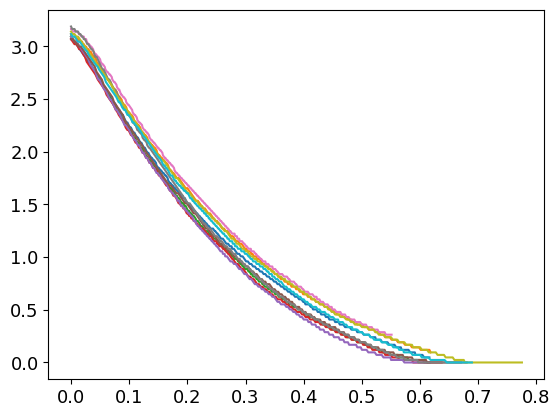

In [313]:
def find_indices_of_end(df):
    indices_of_change = []
    for i in range(len(df) - 1):
        if df['U'].iloc[i] == 0 and df['U'].iloc[i - 1] != 0:
            indices_of_change.append(i)
    return indices_of_change

df_ending = []
for df in processed_dataframes:
    index = find_indices_of_end(df)[0]
    df = df[index+15:index+290].reset_index(drop=True)
    # df = df[(df['U'] == 0) & (df['U'].shift(1) != 0)][:].reset_index(drop=True)
    plt.plot(df['t']-df['t'].iloc[0], abs(df['DXL_Velocity']))
    df_ending.append(df)

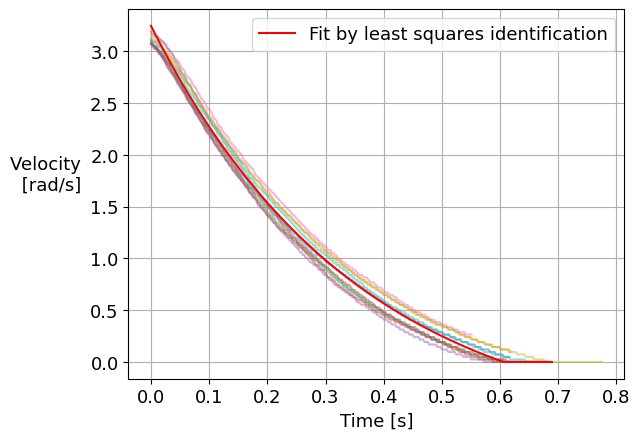

Estimated C1: 3.965855320311614, Estimated tau_1: 0.3552282066318358, Estimated tau_c_on_cv: 0.7213914247449792, R^2: 0.9918252072080379


In [326]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Define the model function
def model_func(t, C1, tau_1, tau_c_on_cv):
    result = C1 * np.exp(-t / tau_1) - tau_c_on_cv
    return np.where(result < 0, 0, result)

# def model_func(t, C1, tau_1, tau_c_on_cv):
#     return (C1 + tau_c_on_cv * t) * np.exp(-t / tau_1)


# Initialize arrays to hold all data
all_t = np.array([])
all_velocity = np.array([])

# Concatenate data from all dataframes
for df in df_ending:
    t = df['t'] - df['t'].iloc[0]
    velocity = abs(df['DXL_Velocity'].reset_index(drop=True))
    
    all_t = np.concatenate((all_t, t))
    all_velocity = np.concatenate((all_velocity, velocity))

# Perform the curve fitting on the concatenated data
initial_guess_C1, initial_guess_tau_1, initial_guess_tau_c_on_cv = 3.857580215620395, 0.31611416531757025, 0.5829825798689353
popt, pcov = curve_fit(model_func, all_t, all_velocity, p0=[initial_guess_C1, initial_guess_tau_1, initial_guess_tau_c_on_cv])

# Extract the best-fit parameters
C1, tau_1, tau_c_on_cv = popt

# Calculate the estimated velocity using the obtained parameters for each experiment
for df in df_ending:
    t = df['t'] - df['t'].iloc[0]
    velocity = abs(df['DXL_Velocity'].reset_index(drop=True))

    estimated_velocity = model_func(t, C1, tau_1, tau_c_on_cv)

    # Plot the results for each experiment
    plt.plot(t, velocity, alpha = 0.5)
    
plt.plot(t, estimated_velocity, 'r-', label='Fit by least squares identification')
plt.xlabel("Time [s]")
plt.ylabel("Velocity \n [rad/s]", rotation=0, labelpad=30)
plt.legend()
plt.grid()
plt.show()

# Calculate R^2 value
residuals = all_velocity - model_func(all_t, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((all_velocity - np.mean(all_velocity))**2)
r_squared = 1 - (ss_res / ss_tot)

# Return the estimated parameters and R^2 value
print(f"Estimated C1: {C1}, Estimated tau_1: {tau_1}, Estimated tau_c_on_cv: {tau_c_on_cv}, R^2: {r_squared}")


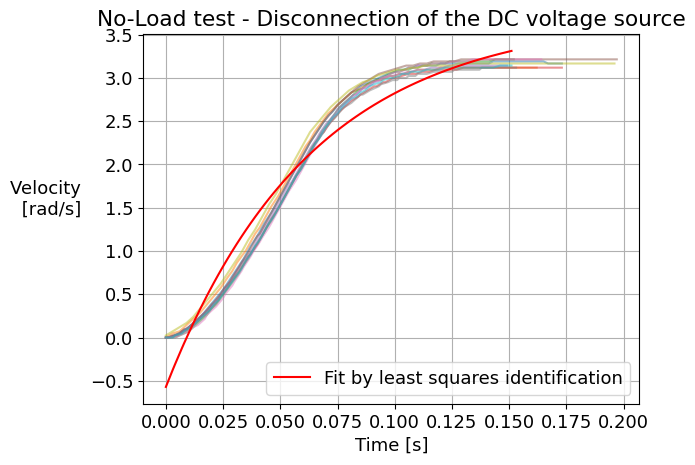

Estimated C2: -4.277562701281803, Estimated tau_2: 0.06346336997590714, Estimated term: 3.706926145623689


In [304]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the model function
def model_func(t, C2, tau_2, term):
    return C2 * np.exp(-t / tau_2) + term

# Initialize arrays to hold all data
all_t = np.array([])
all_velocity = np.array([])

# Concatenate data from all dataframes
for df in df_starting:
    t = df['t'] - df['t'].iloc[0]
    velocity = abs(df['DXL_Velocity'].reset_index(drop=True))
    
    all_t = np.concatenate((all_t, t))
    all_velocity = np.concatenate((all_velocity, velocity))

# Perform the curve fitting on the concatenated data
initial_guess_C2, initial_guess_tau_2, initial_guess_term = -4.277570390518172, 0.06346435020128945, 3.706947247536115
popt, pcov = curve_fit(model_func, all_t, all_velocity, p0=[initial_guess_C2, initial_guess_tau_2, initial_guess_term])

# Extract the best-fit parameters
C2, tau_2, term = popt

# Calculate the estimated velocity using the obtained parameters for each experiment
for df in df_starting:
    t = df['t'] - df['t'].iloc[0]
    velocity = abs(df['DXL_Velocity'].reset_index(drop=True))

    estimated_velocity = model_func(t, C2, tau_2, term)

    # Plot the results for each experiment
    plt.plot(t, velocity, alpha = 0.5)
plt.plot(t, estimated_velocity, 'r-', label='Fit by least squares identification')
plt.xlabel("Time [s]")
plt.ylabel("Velocity \n [rad/s]", rotation=0, labelpad=30)
plt.title("No-Load test - Disconnection of the DC voltage source")
plt.legend()
plt.grid()
plt.show()

# Return the estimated parameters
print(f"Estimated C2: {C2}, Estimated tau_2: {tau_2}, Estimated term: {term}")
# popt

3.176515598986314

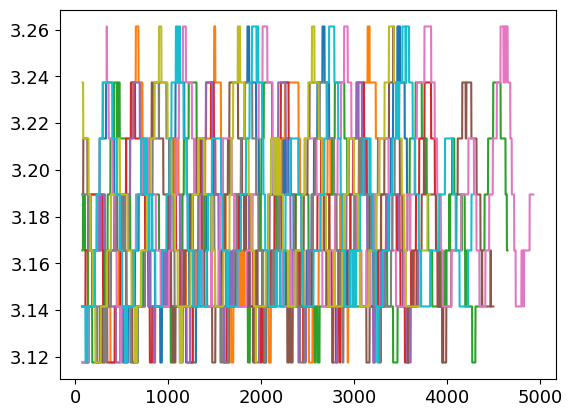

In [315]:
v_f = []
for df in processed_dataframes:
    df = df[:]
    # df = df[df['U'] != 0][:100].reset_index(drop=True)
    # plt.plot(df['t']-df['t'].iloc[0], abs(df['DXL_Velocity']))
    df = df[df['U'] != 0].reset_index(drop=True)

    plt.plot(abs(df['DXL_Velocity'][80:]))
    v_f.append(abs(df['DXL_Velocity'][80:].mean()))

import statistics
statistics.mean(v_f)

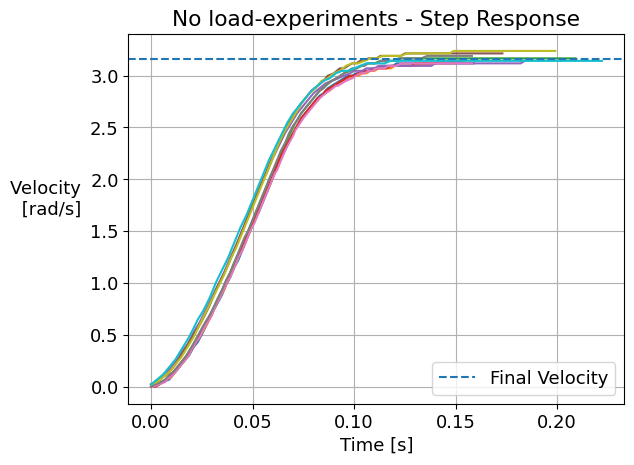

Estimated time constants: [0.06099999999999994, 0.06000000000000005, 0.05899999999999972, 0.06000000000000005, 0.05699999999999994, 0.05600000000000005, 0.06099999999999994, 0.06000000000000005, 0.05699999999999994, 0.05500000000000016]
0.058599999999999985


In [322]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set the font size globally
mpl.rcParams.update({'font.size': 13})  # Change 14 to your desired font size

def estimate_time_constant(df_starting):
    time_constants = []

    for df in df_starting:
        t = df['t'] - df['t'].iloc[0]
        velocity = abs(df['DXL_Velocity'])

        # Plot the response
        plt.plot(t, velocity)

        # Determine the final steady-state value as the average of the last few points
        steady_state_value = np.mean(velocity[-5:])

        # Calculate 63.2% of the steady-state value
        target_value = 0.632 * steady_state_value
        # target_value = 0.95 * steady_state_value

        # Find the time at which the velocity first exceeds the target value
        time_constant_index = np.where(velocity >= target_value)[0][0]
        time_constant = t[time_constant_index]

        # Save the estimated time constant
        time_constants.append(time_constant)

    plt.axhline(3.1564828409997125, linestyle='--', label="Final Velocity")
    plt.xlabel('Time [s]')
    plt.ylabel("Velocity \n [rad/s]", rotation=0, labelpad=30)
    plt.title("No load-experiments - Step Response")
    plt.grid()
    plt.legend()
    plt.show()

    return time_constants

# Assuming 'processed_dataframes' is a list of dataframes
time_constants = estimate_time_constant(df_starting)
print("Estimated time constants:", time_constants)
tau_2 = statistics.mean(time_constants)
print(tau_2)

/var/folders/3b/gndgh3_j0mn3vgdx4cl1k6g00000gn/T/ipykernel_81023/36624352.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  time_constant = steady_state_value / initial_slope


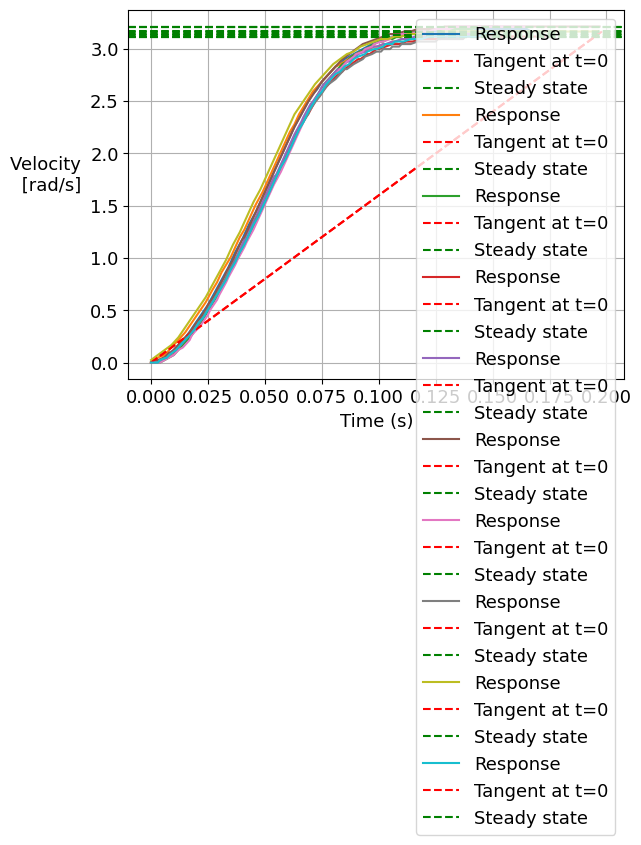

Estimated time constants using tangent: [inf, 0.19500000000000736, inf, inf, inf, inf, inf, inf, 0.19799999999989026, inf]
Average time constant: inf


In [307]:
import numpy as np
import matplotlib.pyplot as plt
import statistics

def estimate_time_constant_using_tangent(df_starting):
    time_constants = []

    for df in df_starting:
        # df = df[10:]
        t = df['t'] - df['t'].iloc[0]
        velocity = abs(df['DXL_Velocity'])

        # Determine the final steady-state value as the average of the last few points
        steady_state_value = np.mean(velocity[-5:])

        # Calculate the slope of the tangent line at t=0 (initial rate of change)
        initial_slope = (velocity[1] - velocity[0]) / (t[1] - t[0])

        # The time constant is then the final value divided by the initial slope
        time_constant = steady_state_value / initial_slope

        # Save the estimated time constant
        time_constants.append(time_constant)

        # Plot the response and the tangent line
        plt.plot(t, velocity, label='Response')
        plt.plot([0, time_constant], [0, steady_state_value], 'r--', label='Tangent at t=0')
        plt.axhline(steady_state_value, color='g', linestyle='--', label='Steady state')

    plt.xlabel('Time (s)')
    plt.ylabel("Velocity \n [rad/s]", rotation=0, labelpad=30)
    plt.legend()
    plt.grid()
    plt.show()

    return time_constants

# Assuming 'processed_dataframes' is a list of dataframes
time_constants = estimate_time_constant_using_tangent(df_starting)
print("Estimated time constants using tangent:", time_constants)
tau_2 = statistics.mean(time_constants)
print("Average time constant:", tau_2)


In [327]:
Ra = 9.3756 # [Ohm]
kt = 2.6657
ke = kt
ke = 3.6103 #/ 353
external_inertia = 0.0022421143208 # Msolo
external_inertia = 0
# tau_2 = 0.195

J = ((ke*kt/Ra) * tau_2)/(1 - tau_2/tau_1)
c_v = J / tau_1
tau_c = tau_c_on_cv * c_v
J_motor = J - external_inertia
tau_c, c_v, J_motor

(0.14628898896564263, 0.20278725799569575, 0.0720357539855984)

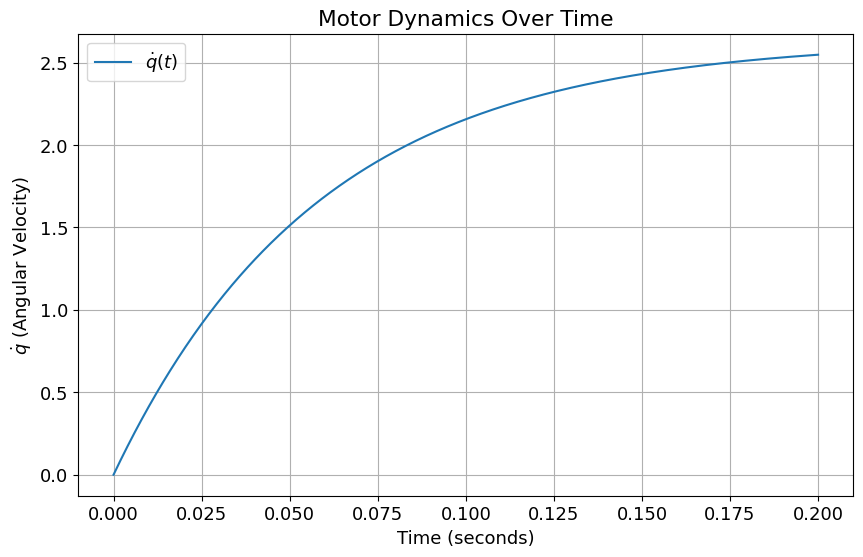

In [309]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
# (0.12834928717151478, 0.22012086337018552, 0.0730515032605435) on test 2
# (0.1341642041622763, 0.24573070847108586, 0.07620612947080237) on exp 1
# Given constants
Ra = 9.3756  # Ohm
kt = 2.6657
ke = 3.6103
# tau_c = 0.134
# c_v = 0.2457
# J = 0.0762
U_a = 12
tau_c = 0.12834928717151478
c_v = 0.22012086337018552
J = 0.0730515032605435

# Differential equation
def motor_dynamics(q_dot, t, Ra, kt, ke, tau_c, c_v, J, U_a):
    return ((kt * U_a / Ra) - tau_c - (kt * ke / Ra + c_v) * q_dot) / J

# Time span for the simulation (arbitrary choice, can be modified)
t = np.linspace(0, 0.2, 1000)  # 5 seconds, 1000 points

# Initial condition
q_dot_0 = 0

# Solve the differential equation
q_dot = odeint(motor_dynamics, q_dot_0, t, args=(Ra, kt, ke, tau_c, c_v, J, U_a))

# Plotting the result
plt.figure(figsize=(10, 6))
plt.plot(t, q_dot, label=r'$\dot{q}(t)$')
plt.title('Motor Dynamics Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel(r'$\dot{q}$ (Angular Velocity)')
plt.legend()
plt.grid(True)
plt.show()


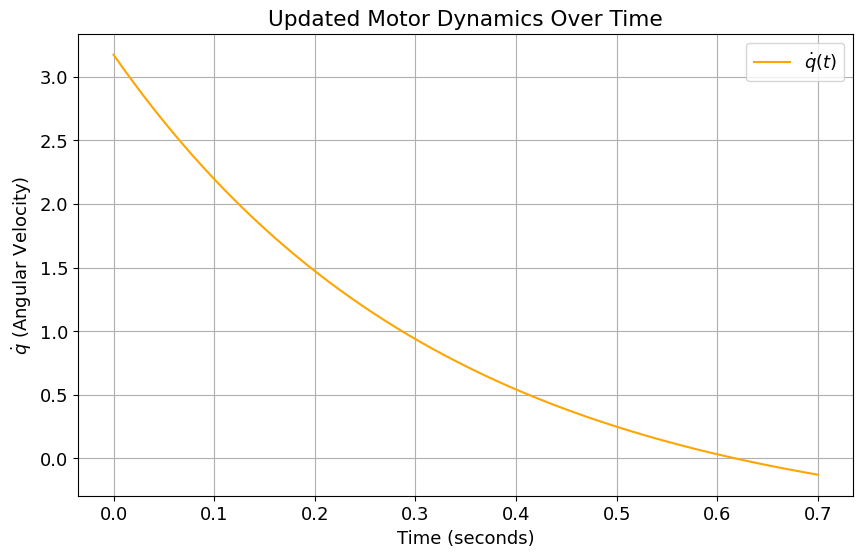

In [310]:
# Updated differential equation
def motor_dynamics_updated(q_dot, t, tau_c, c_v, J):
    return (-tau_c - c_v * q_dot) / J

q_dot_0 = 3.171292162136999
t = np.linspace(0, 0.7, 1000)  # 5 seconds, 1000 points

# Solve the updated differential equation
q_dot_updated = odeint(motor_dynamics_updated, q_dot_0, t, args=(tau_c, c_v, J))

# Plotting the result
plt.figure(figsize=(10, 6))
plt.plot(t, q_dot_updated, label=r'$\dot{q}(t)$', color='orange')
plt.title('Updated Motor Dynamics Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel(r'$\dot{q}$ (Angular Velocity)')
plt.legend()
plt.grid(True)
plt.show()
